# 作業 : (Kaggle)房價預測

# [作業目標]
- 試著模仿範例寫法, 在房價預測中, 觀察去除離群值的影響

# [作業重點]
- 觀察將極端值以上下限值取代, 對於分布與迴歸分數的影響 (In[5], Out[5])
- 觀察將極端值資料直接刪除, 對於分布與迴歸分數的影響 (In[6], Out[6])

In [1]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

data_path = '/Users/YenLin/Desktop/ML_100/data/'
df_train = pd.read_csv(data_path + 'house_train.csv.gz')

train_Y = np.log1p(df_train['SalePrice'])
df = df_train.drop(['Id', 'SalePrice'] , axis=1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [2]:
#只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)
print(f'{len(num_features)} Numeric Features : {num_features}\n')

36 Numeric Features : ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']



In [3]:
# 削減文字型欄位, 只剩數值型欄位
df = df[num_features].astype( float )
df = df.fillna(-1)
MMEncoder = MinMaxScaler( )
train_num = train_Y.shape[0]
df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,...,548.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,...,460.0,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,...,608.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0
3,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,...,642.0,0.0,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0
4,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,...,836.0,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0


# 作業1
* 試著限制 '1樓地板面積(平方英尺)' (1stFlrSF) 欄位的上下限, 看看能否再進一步提高分數?

In [4]:
# 顯示 1stFlrSF 與目標值的散佈圖
import seaborn as sns
import matplotlib.pyplot as plt
sns.regplot( x = df[ '1stFlrSF' ][ : train_num ], y = train_Y )
plt.show()

# 做線性迴歸, 觀察分數
train_X = MMEncoder.fit_transform( df )
estimator = LinearRegression( )
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

<Figure size 640x480 with 1 Axes>

0.8444603016888553

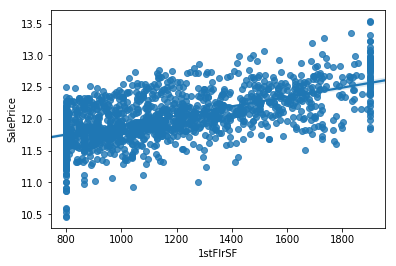

0.8517382410821381

In [5]:
# 將 1stFlrSF 限制在你覺得適合的範圍內, 調整離群值
df[ '1stFlrSF' ] = df[ '1stFlrSF' ].clip(800, 1900)
sns.regplot( x = df[ '1stFlrSF' ][ : train_num ], y = train_Y )
plt.show()

# 做線性迴歸, 觀察分數
train_X = MMEncoder.fit_transform( df )
estimator = LinearRegression()
cross_val_score( estimator, train_X, train_Y, cv = 5 ).mean( )

# 作業2
* 續前題, 去除離群值有兩類方式 :  捨棄離群值(刪除離群的資料) 以及調整離群值,  
請試著用同樣的上下限, 改為 '捨棄離群值' 的方法, 看看結果會變好還是變差? 並試著解釋原因。  

#### Answer : 捨棄離群值的方法讓模擬效果提升。若捨棄離群值的個數不多，則此方法不致於對原始資料的分布產生很大變化。


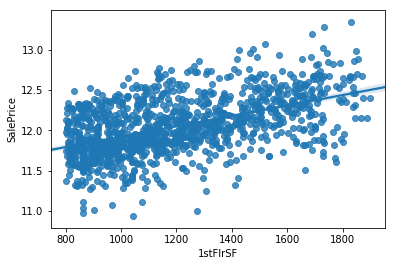

0.8822213601503426

In [6]:
# 將 1stFlrSF 限制在你覺得適合的範圍內, 捨棄離群值
keep_indexs = ( df[ '1stFlrSF' ] > 800 ) & ( df[ '1stFlrSF' ] < 1900 )
df = df[ keep_indexs ]
train_Y = train_Y[ keep_indexs ]
sns.regplot( x = df[ '1stFlrSF' ], y = train_Y )
plt.show()

# 做線性迴歸, 觀察分數
train_X = MMEncoder.fit_transform( df )
estimator = LinearRegression( )
cross_val_score( estimator, train_X, train_Y, cv = 5 ).mean( )